# Большая лабораторная работа

## Актуальный код

Импортируем бибилотеки

In [1]:
from matplotlib import pyplot as plt
from matplotlib import cm
from matplotlib.patches import Rectangle
from imageio import imread, imsave
import numpy as np
from skimage.color import rgb2gray
from skimage.feature import canny
from skimage.filters import gaussian
from skimage.filters import try_all_threshold
from skimage.filters import threshold_otsu, threshold_triangle, rank
from skimage.morphology import binary_closing
from skimage.morphology import binary_opening
from skimage.morphology import disk
import skimage.segmentation as seg
import random as rng
import cv2
import os

### Вспомогательные функции отрисовки

In [2]:
def circle_points(resolution, center, radius):  
    radians = np.linspace(0, 2*np.pi, resolution)
    c = center[1] + radius*np.cos(radians)#polar co-ordinates
    r = center[0] + radius*np.sin(radians)
    
    return np.array([c, r]).T

def image_show(image, nrows=1, ncols=1, cmap='gray'):
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(14, 14))
    ax.imshow(image, cmap='gray')
    ax.axis('off')
    return fig, ax

### Загрузка имен изображений
#### Предполагается что в папках ничего кроме изображений нет и имена картинок и соответствующих им масок совпадают

In [3]:
data_path = "data\\img"
mask_path = "data\\lbl"
lbl_names = os.listdir(mask_path)
img_names = os.listdir(data_path)

### Функция для агрегирования шаблонов

In [4]:
def get_templates(path):
    res = []
    names = os.listdir(path)
    for name in names:
        img = cv2.imread(os.path.join(path, name), cv2.IMREAD_GRAYSCALE)
        img = cv2.morphologyEx(img, cv2.MORPH_OPEN, np.ones((3, 3)))
        cnts = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cnts = cnts[0] if len(cnts) == 2 else cnts[1]
        for c in cnts:
            if cv2.contourArea(c) > cv2.arcLength(c, True):
                msk = np.zeros_like(img)
                cv2.drawContours(msk, [c], -1, (255, 255, 255), thickness=1)
                pdp = cv2.approxPolyDP(c, 3, True)
                x, y, w, h = cv2.boundingRect(pdp)
                roi = msk[y:y+h, x:x+w]
                res.append(roi)
            
    return res

#### Функция сопоставления контура и шаблона ногтя

In [5]:
templates = get_templates(mask_path)
def is_nail(cntr, threshold=0.8):
    tmp = np.zeros((256, 256)).astype(np.uint8)
    cv2.drawContours(tmp, [cntr], -1, (255, 255, 255), thickness=1)
    for template in templates:
        # print(type(tmp), type(template))
        # print(tmp.shape, template.shape)
        res = cv2.matchTemplate(tmp, template, cv2.TM_CCOEFF_NORMED)
        loc = np.any( res >= threshold)
        if loc:
            return True
    return False

### Подбор порога для canny

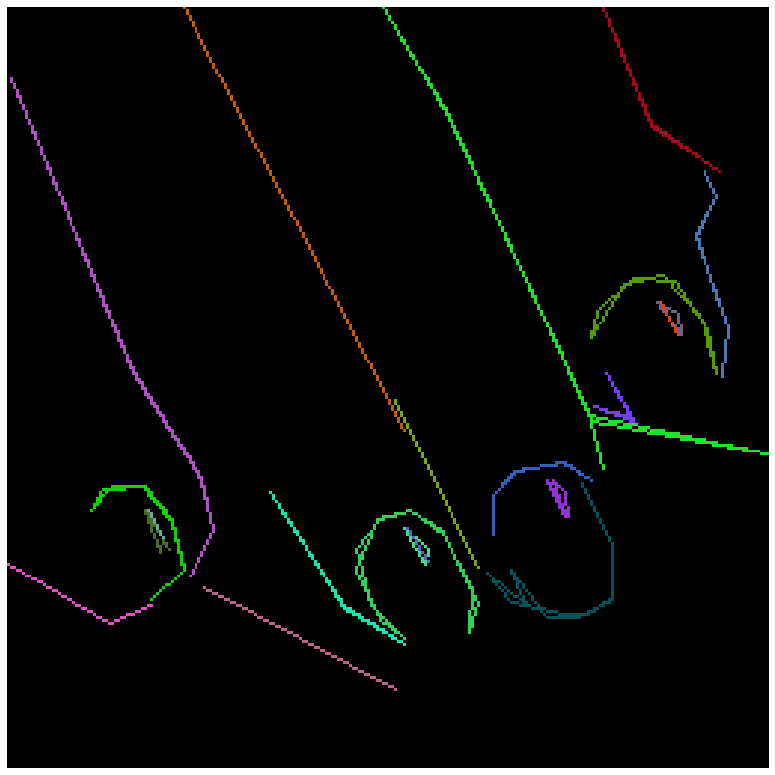

In [7]:
rng.seed(12345)

def thresh_callback(val):
    threshold = val

    canny_output = cv.Canny(src_gray, threshold, threshold * 2)
    
    _, contours, _ = cv.findContours(canny_output, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
    
    contours_poly = [None]*len(contours)
    boundRect = [None]*len(contours)
    centers = [None]*len(contours)
    radius = [None]*len(contours)
    closed = [None]*len(contours)
    for i, c in enumerate(contours):
        contours_poly[i] = cv.approxPolyDP(c, 3, True)
        boundRect[i] = cv.boundingRect(contours_poly[i])
        centers[i], radius[i] = cv.minEnclosingCircle(contours_poly[i])
        closed[i] = is_nail(c, 0.8)
    

    
    drawing = np.zeros((canny_output.shape[0], canny_output.shape[1], 3), dtype=np.uint8)
    

    color2 = (rng.randint(0,256), rng.randint(0,256), rng.randint(0,256))
    
    for i in range(len(contours)):
        color = (rng.randint(0,256), rng.randint(0,256), rng.randint(0,256))
        cv.drawContours(drawing, contours_poly, i, color)
        if closed[i]:
            cv.rectangle(drawing, (int(boundRect[i][0]), int(boundRect[i][1])), \
              (int(boundRect[i][0]+boundRect[i][2]), int(boundRect[i][1]+boundRect[i][3])), color, 2)
            cv.circle(drawing, (int(centers[i][0]), int(centers[i][1])), int(radius[i]), color, 2)
    

    # image_show(drawing)
    cv.imshow('Contours', drawing)
    

name = img_names[4]
src = cv.imread(os.path.join(data_path, name))
if src is None:
    print('Could not open or find the image:', args.input)
    exit(0)

# Convert image to gray and blur it
src_gray = cv.cvtColor(src, cv.COLOR_BGR2GRAY)
src_gray = cv.blur(src_gray, (3,3))



source_window = 'Source'
cv.namedWindow(source_window)
cv.imshow(source_window, src)

max_thresh = 255
thresh = 100 # initial threshold
cv.createTrackbar('Canny thresh:', source_window, thresh, max_thresh, thresh_callback)
thresh_callback(thresh)

cv.waitKey(0)
cv2.destroyAllWindows()

#### Визуализация детектора orb

In [7]:
img = cv2.imread(os.path.join(data_path, img_names[3]), cv2.IMREAD_GRAYSCALE)
orb = cv2.ORB_create(5000)
kp, desc = orb.detectAndCompute(img,None)

img = cv2.drawKeypoints(img, kp, None)
cv2.imshow("img", img)
cv2.waitKey(0)
cv2.destroyAllWindows()

Как видим из картинки огромное количество шумовых точек

### Cегментация активного контура

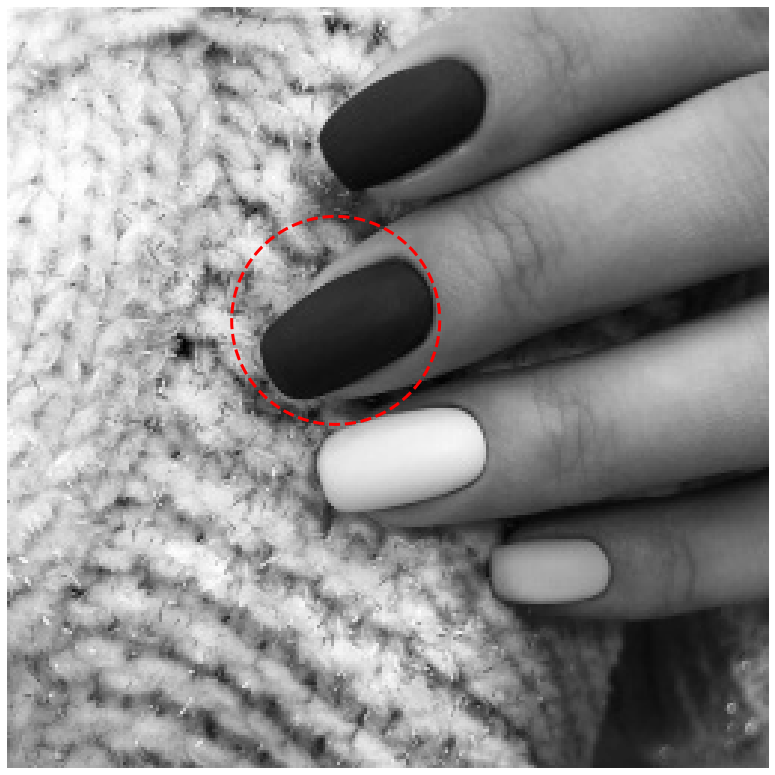

In [13]:
# 1: 200, [40, 135], 35
# 2: 200, [155, 135], 33
# 3: 200, [105, 110], 35
# Exclude last point because a closed path should not have duplicate points
points = circle_points(200, [105, 110], 35)[:-1]
img = cv2.imread(os.path.join(data_path, img_names[20]), cv2.IMREAD_GRAYSCALE)
fig, ax = image_show(img)
ax.plot(points[:, 0], points[:, 1], '--r', lw=3)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: The coordinates used by `active_contour` will change from xy coordinates (transposed from image dimensions) to rc coordinates in scikit-image 0.18. Set `coordinates='rc'` to silence this warning. `coordinates='xy'` will restore the old behavior until 0.18, but will stop working thereafter.
  """Entry point for launching an IPython kernel.


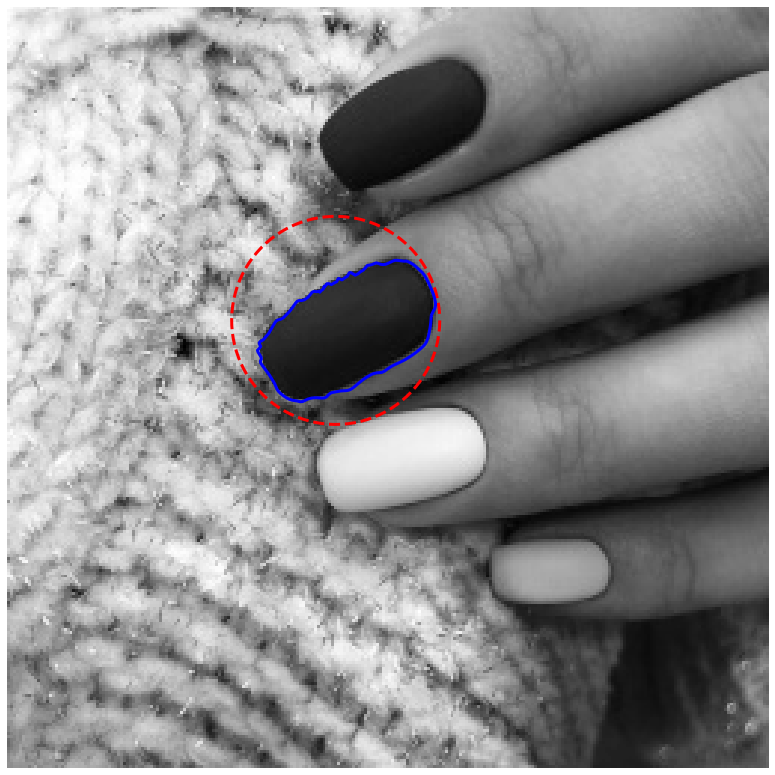

In [14]:
snake = seg.active_contour(img, points,alpha=0.9,beta=0.6)
fig, ax = image_show(img)
ax.plot(points[:, 0], points[:, 1], '--r', lw=3)
ax.plot(snake[:, 0], snake[:, 1], '-b', lw=3);

Методом активного контура можно добиться довольно высокой точности сегментации, но ногтей обычно несколько на одном изображении, но необходимо локализовать каждый ноготь.

### Основная работа

Для решения задачи семантической сегментации. Обучим нейронную сеть на 1287 размеченных изображений.

In [5]:
import numpy as np 
import os
import skimage.io as io
import skimage.transform as trans
import numpy as np
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as K
from keras.callbacks import TensorBoard, Callback
from keras.losses import binary_crossentropy

Using TensorFlow backend.
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py

In [6]:
img_path = 'data/img'
lbl_path = 'data/lbl'

In [7]:
def conv2d_block(input_tensor, n_filters, kernel_size=3, batchnorm=True):
    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), kernel_initializer="he_normal",
    padding="same")(input_tensor)
    
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), kernel_initializer="he_normal",
    padding="same")(x)
    
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    return x


def unet(pretrained_weights=None, input_size=(256, 256, 1), n_filters=32, dropout=0.25, batchnorm=True):
    inputs = Input(input_size)

    c1 = conv2d_block(inputs, n_filters=n_filters*1, kernel_size=3, batchnorm=batchnorm)
    p1 = MaxPooling2D((2, 2))(c1)
 
    p1 = Dropout(dropout*0.5)(p1)
    c2 = conv2d_block(p1, n_filters=n_filters*2, kernel_size=3, batchnorm=batchnorm)
    p2 = MaxPooling2D((2, 2)) (c2)
    p2 = Dropout(dropout)(p2)
    
    c3 = conv2d_block(p2, n_filters=n_filters*4, kernel_size=3, batchnorm=batchnorm)
    p3 = MaxPooling2D((2, 2)) (c3)
    p3 = Dropout(dropout)(p3)

    c4 = conv2d_block(p3, n_filters=n_filters*8, kernel_size=3, batchnorm=batchnorm)
    p4 = MaxPooling2D(pool_size=(2, 2)) (c4)
    p4 = Dropout(dropout)(p4)

    c5 = conv2d_block(p4, n_filters=n_filters*16, kernel_size=3, batchnorm=batchnorm)
    u6 = Conv2DTranspose(n_filters*8, (3, 3), strides=(2, 2), padding='same')(c5)
    u6 = Dropout(dropout)(u6)
    
    c6 = conv2d_block(u6, n_filters=n_filters*8, kernel_size=3, batchnorm=batchnorm) 
    u7 = Conv2DTranspose(n_filters*4, (3, 3), strides=(2, 2), padding='same')(c6)
    u7 = Dropout(dropout)(u7)
    
    c7 = conv2d_block(u7, n_filters=n_filters*4, kernel_size=3, batchnorm=batchnorm)
    u8 = Conv2DTranspose(n_filters*2, (3, 3), strides=(2, 2), padding='same')(c7)
    u9 = Conv2DTranspose(n_filters*1, (1, 1), strides=(2, 2), padding='same')(u8)
   

    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters=n_filters*1, kernel_size=3, batchnorm=batchnorm)
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
    model = Model(inputs=[inputs], outputs=[outputs])

    model.compile(optimizer=Adam(lr=1e-4), loss=bce_dice_loss, metrics=['accuracy', dice_coef])
    
    model.summary()

    if pretrained_weights:
        model.load_weights(pretrained_weights)

    return model

In [8]:
def dice_coef(y_true, y_pred, smooth=1):
    """
    Dice = (2*|X & Y|)/ (|X|+ |Y|)
         =  2*sum(|A*B|)/(sum(A^2)+sum(B^2))
    ref: https://arxiv.org/pdf/1606.04797v1.pdf
    """
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    return (2. * intersection + smooth) / (K.sum(K.square(y_true),-1) + K.sum(K.square(y_pred),-1) + smooth)

def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)

def bce_dice_loss(y_true, y_pred):
    return dice_coef_loss(y_true, y_pred) + binary_crossentropy(y_true, y_pred)

In [9]:
model = unet('weights/unet2_32_grayscale.hdf5')


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 256, 256, 1)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 256, 256, 32)      320       
_________________________________________________________________
batch_normalization_1 (Batch (None, 256, 256, 32)      128       
_________________________________________________________________
activation_1 (Activation)    (None, 256, 256, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 256, 256, 32)      9248      
_________________________________________________________________
batch_normalization_2 (Batch (None, 256, 256, 32)      128       
______________________________

In [11]:
def iou(y_true, y_pred):
    intersect_area = np.sum(y_true * y_pred)
    union_area = np.sum(y_true) + np.sum(y_pred) - intersect_area

    return intersect_area / union_area

mean_iou_morph, mean_iou = 0., 0.
min_iou = 2.0

for name in os.listdir(img_path):
    img = cv2.imread(os.path.join(img_path, name), 0)
    lbl = cv2.imread(os.path.join(lbl_path, name), 0)
    img = img/255.
    lbl = lbl/255.
    predict = model.predict(img.reshape((1, 256, 256, 1)))
    predict[predict > 0.5] = 1
    predict[predict <= 0.5] = 0
    predict = predict.reshape(256, 256)
    mean_iou += iou(lbl, predict)
    predict = cv2.morphologyEx(predict, cv2.MORPH_OPEN, np.ones((3, 3)))
    iou_t = iou(lbl, predict)
    mean_iou_morph += iou_t
    min_iou = min(min_iou, iou_t)
    
mean_iou /= len(os.listdir(img_path))
mean_iou_morph /= len(os.listdir(img_path))
print("Mean intersection of union without morph:", mean_iou)
print("Mean intersection of union:", mean_iou_morph)

Mean intersection of union without morph: 0.821524686427706
Mean intersection of union: 0.8216338116912081


In [13]:
print(min_iou)

0.2126672857078948
